tree data: torch.Size([128, 119, 3]), block_sizes_pos: torch.Size([128, 120, 4]),pins_pos: torch.Size([128, 283, 2]), b2b_connectivity: torch.Size([128, 120, 120]),p2b_connectivity: torch.Size([128, 120, 283]), edge_constraints: torch.Size([128, 120, 2]), preplaced : torch.Size([128, 120]), fixed : torch.Size([128, 120]), tied_ar_ids : torch.Size([128, 120]), group_mask : torch.Size([128, 120])


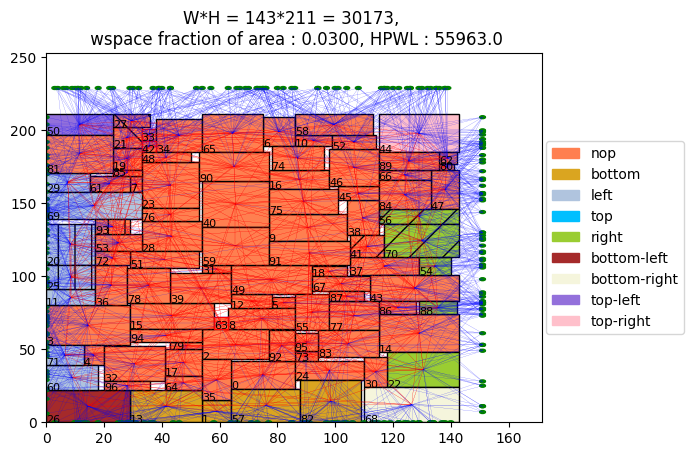

In [23]:
import torch
from torch.utils.data import DataLoader

from lite_dataset import FloorplanDataset, floorplan_collate
from visualize import visualize_placement


def main():
    root = './'
    ds = FloorplanDataset(root)
    # Avoid shuffling to make file caching more effective
    dl = DataLoader(ds, batch_size=128, shuffle=False,
                    collate_fn=floorplan_collate)
    
    # A minibatch can contain floorplans with different number of blocks or pins
    # All tensors in a minibatch are padded to the maximum number of blocks and pins in the minibatch
    # The padding for the LongTensors is -1, for the bool tensors it is False
    for (tree_data,  # bsz x (n_blocks-1) x 3 . The B*Tree representation of the floorplans
         # bsz x n_blocks x 4. The size(:,:,:2) and the ground truth position(:,:,2:4) of the blocks
         block_sizes_pos,
         pins_pos,  # bsz x n_pins x 2. The pins location
         b2b_connectivity,  # bsz x n_blocks x n_blocks . The block-to-block connectivity
         p2b_connectivity,  # bsz x n_blocks x n_pins. The 
         edge_constraints, # bsz x n_blocks x 2. See visualize.py for the interpretation of edge constraints
         preplaced, #bsz x n_blocks Boolean mask. True for preplaced blocks
         fixed, #bsz x n_blocks Boolean mask. True for fixed aspect-ratio blocks
         tied_ar_ids, #bsz x n_blocks. Blocks that share the same non-zero tied_ar_ids must have the same aspect ratio
         group_mask #bsz x n_blocks. Blocks that share the same non-zero group mask must be grouped together
         ) in dl:  # bsz x n_blocks x 2. See visualize.py for the interpretation of edge constraints
        print(
            f'tree data: {tree_data.size()}, block_sizes_pos: {block_sizes_pos.size()},pins_pos: {pins_pos.size()}, b2b_connectivity: {b2b_connectivity.size()},p2b_connectivity: {p2b_connectivity.size()}, edge_constraints: {edge_constraints.size()}, preplaced : {preplaced.size()}, fixed : {fixed.size()}, tied_ar_ids : {tied_ar_ids.size()}, group_mask : {group_mask.size()}')
        break
    
    # Visualize the first element in the dataset
    (tree_data, block_sizes_pos, pins_pos, b2b_connectivity, p2b_connectivity, edge_constraints,
     preplaced, fixed, tied_ar_ids, group_mask) = ds[0]    
    
    visualize_placement(block_sizes_pos[:, :2],
                        block_sizes_pos[:, 2:4],
                        pins_pos,
                        edge_constraints,
                        group_mask.long(),
                        tied_ar_ids,
                        b2b_connectivity,
                        p2b_connectivity)


if __name__ == "__main__":
    main()
